In [1]:
import os
import sys

problems_path = os.path.abspath(os.path.join('test_problems'))
solver_path = os.path.abspath(os.path.join('../'))
fig_path = os.path.abspath(os.path.join('./figs'))
data_path = os.path.abspath(os.path.join('./data'))
os.makedirs(fig_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)
if problems_path not in sys.path:
    sys.path.append(problems_path)
if solver_path not in sys.path:
    sys.path.append(solver_path)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

rc('text', usetex=True)

In [3]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2
from problems import JOS1, JOS1_L1, SD, FDS, FDS_CONSTRAINED
from zfista import minimize_proximal_gradient

In [4]:
def generate_start_points(low, high, n_dims, n_samples=1000):
    return [np.random.uniform(low=low, high=high, size=n_dims) for _ in
            range(n_samples)]


def run(problem, start_points, tol=1e-5, nesterov=False,
        nesterov_ratio=(0, 0.25), n_jobs=-1, verbose=False):
    results = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(minimize_proximal_gradient)(problem.f, problem.g,
                                            problem.jac_f, problem.prox_wsum_g,
                                            x0,
                                            tol=tol, nesterov=nesterov,
                                            nesterov_ratio=nesterov_ratio,
                                            return_all=True, verbose=verbose)
        for x0 in start_points)
    return results


def show_Pareto_front(problem, results, results_nesterov, step=None, s=15,
                      alpha=0.75, fname=None, elev=15, azim=130, linewidths=.1):
    labels = ["Starting points", f"PGM ($k={step}$)", f"Acc-PGM ($k={step}$)",
              "PGM (Solutions)", "Acc-PGM (Solutions)"]
    fig = plt.figure(figsize=(7.5, 7.5), dpi=100)
    if problem.m_dims == 2:
        ax = fig.add_subplot(111)
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    if problem.m_dims == 3:
        ax = fig.add_subplot(111, projection='3d', clip_on=True)
        ax.view_init(elev=elev, azim=azim)
        fig.subplots_adjust(left=0, right=1, bottom=0, top=0.6)
    for i, (result, result_acc) in tqdm(
            enumerate(zip(results, results_nesterov))):
        allvecs = result.allvecs
        allvecs_acc = result_acc.allvecs
        x0 = allvecs[0]
        F_of_x0 = problem.f(x0) + problem.g(x0)
        if step is not None:
            xk = allvecs[step]
            xk_acc = allvecs_acc[step]
            F_of_xk = problem.f(xk) + problem.g(xk)
            F_of_xk_acc = problem.f(xk_acc) + problem.g(xk_acc)
        F_pareto = result.fun
        F_pareto_acc = result_acc.fun
        if problem.m_dims == 2:
            ax.scatter(*F_of_x0, color="#8e44ad", marker="x", label=labels[0], s=s, alpha=alpha, linewidths=linewidths)
            if step is not None:
                ax.scatter(*F_of_xk, color="#2980b9",
                       marker="<", label=labels[1], s=s, alpha=alpha, linewidths=linewidths)
                ax.scatter(*F_of_xk_acc, facecolors='none', edgecolor="#e74c3c", marker="*",
                       label=labels[2], s=s, alpha=alpha, linewidths=linewidths)
        ax.scatter(*F_pareto, color="#2980b9",
                   marker=".", label=labels[3], s=s, alpha=alpha, linewidths=linewidths)
        ax.scatter(*F_pareto_acc, facecolors='none', edgecolors="#e74c3c", marker="D",
                   label=labels[4], s=s, alpha=alpha, linewidths=linewidths)
    ax.set_xlabel(r'$F_1$', fontsize=15)
    ax.set_ylabel(r'$F_2$', fontsize=15)
    if problem.m_dims == 3:
        ax.set_zlabel(r'$F_3$', fontsize=15)
        ax.legend(labels[-2:], bbox_transform=ax.transData)
    elif step is None:
        ax.legend([labels[0]] + labels[-2:])
    else:
        ax.legend(labels)
    if fname is not None:
        plt.savefig(fig_path + '/' + fname, bbox_inches='tight')


def get_stats(results):
    nits = [result.nit for result in results]
    nit_internals = [result.nit_internal for result in results]
    execution_times = [result.execution_time for result in results]
    stats = {'nit': {'mean': np.mean(nits), 'std': np.std(nits),
                     'max': np.max(nits)},
             'nit_internal': {'mean': np.mean(nit_internals),
                              'std': np.std(nit_internals),
                              'max': np.max(nit_internals)},
             'execusion_time': {'mean': np.mean(execution_times),
                                'std': np.std(execution_times),
                                'max': np.max(execution_times)}}
    return stats

## JOS1
Minimize
$$
f_1(x) = \frac{1}{n} \| x \|_2^2, \quad f_2(x) = \frac{1}{n} \| x - 2\|_2^2
$$
subject to $x \in \mathbf{R^n}$.

In [5]:
n_dims = 50
problem_JOS1 = JOS1(n_dims=n_dims)
start_points_JOS1 = generate_start_points(low=-2, high=4, n_dims=n_dims)

### Proximal Gradient Method

In [6]:
results_JOS1 = run(problem_JOS1, start_points_JOS1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6

### Accelerated Proximal Gradient Method

In [7]:
results_acc_JOS1 = run(problem_JOS1, start_points_JOS1, nesterov=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1

### Complexity

In [8]:
import pprint

stats_JOS1 = {'PGM': get_stats(results_JOS1), 'Acc-PGM': get_stats(results_acc_JOS1)}
pprint.pprint(stats_JOS1)

{'Acc-PGM': {'execusion_time': {'max': 7.526378870010376,
                                'mean': 3.551971942663193,
                                'std': 0.682663381961295},
             'nit': {'max': 65, 'mean': 65.0, 'std': 0.0},
             'nit_internal': {'max': 1235,
                              'mean': 955.452,
                              'std': 66.64888368157415}},
 'PGM': {'execusion_time': {'max': 34.98148274421692,
                            'mean': 15.515821897506713,
                            'std': 4.104958754295941},
         'nit': {'max': 235, 'mean': 231.695, 'std': 1.1144393209143333},
         'nit_internal': {'max': 4465,
                          'mean': 3412.14,
                          'std': 245.34076383675014}}}


0it [00:00, ?it/s]

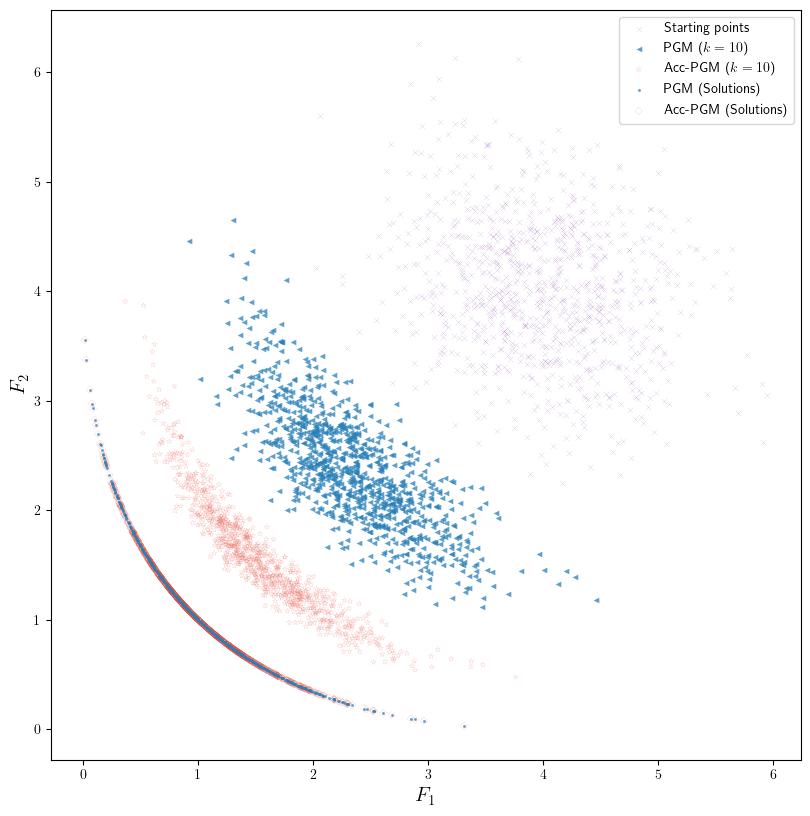

In [9]:
show_Pareto_front(problem_JOS1, results_JOS1, results_acc_JOS1, step=10, fname='JOS1.pdf')

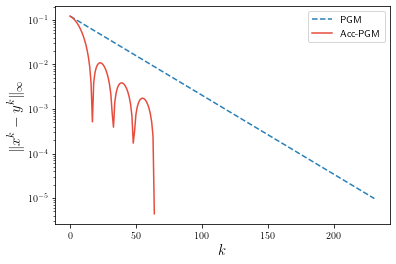

In [18]:
plt.yscale('log')
plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$\|x^k - y^k\|_\infty$', fontsize=15)
plt.plot(results_JOS1[0].all_error_criteria, color="#2980b9", label="PGM", linestyle="dashed")
plt.plot(results_acc_JOS1[0].all_error_criteria, color="#e74c3c", label="Acc-PGM")
plt.legend()
plt.savefig(fig_path + '/JOS1_error.pdf', bbox_inches='tight')

## JOS1 + $\ell_1$ penalty
Minimize
$$
F_1(x) = \frac{1}{n} \| x \|_2^2 + \frac{1}{n} \|x\|_1, \quad F_2(x) = \frac{1}{n} \| x - 2\|_2^2 + \frac{1}{2n} \|x - 1\|_1
$$
subject to $x \in \mathbf{R}^n$.

In [19]:
n_dims = 50
problem_JOS1_L1 = JOS1_L1(n_dims=n_dims, l1_ratios=(1 / n_dims, 1 / n_dims / 2))
start_points_JOS1_L1 = generate_start_points(low=-2, high=4, n_dims=n_dims)

### Proximal Gradient Method

In [20]:
results_JOS1_L1 = run(problem_JOS1_L1, start_points_JOS1_L1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   28.2s
/Users/zalgo/.anyenv/envs/pyenv/versions/3.9.9/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
/Users/zalgo/.anyenv/envs/pyenv/versions/3.9.9/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is lin

### Accelerated Proximal Gradient Method

In [21]:
results_acc_JOS1_L1 = run(problem_JOS1_L1, start_points_JOS1_L1, nesterov=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3

### Complexity

In [22]:
stats_JOS1_L1 = {'PGM': get_stats(results_JOS1_L1), 'Acc-PGM': get_stats(results_acc_JOS1_L1)}
pprint.pprint(stats_JOS1_L1)

{'Acc-PGM': {'execusion_time': {'max': 14.226330995559692,
                                'mean': 8.533853553533554,
                                'std': 1.423249701812492},
             'nit': {'max': 186, 'mean': 161.187, 'std': 17.407700336345407},
             'nit_internal': {'max': 3564,
                              'mean': 2441.181,
                              'std': 323.732460897884}},
 'PGM': {'execusion_time': {'max': 48.52496600151062,
                            'mean': 13.158561500310897,
                            'std': 2.650270226217706},
         'nit': {'max': 273, 'mean': 219.594, 'std': 7.751591062485172},
         'nit_internal': {'max': 10795,
                          'mean': 3331.307,
                          'std': 429.37135529865054}}}


0it [00:00, ?it/s]

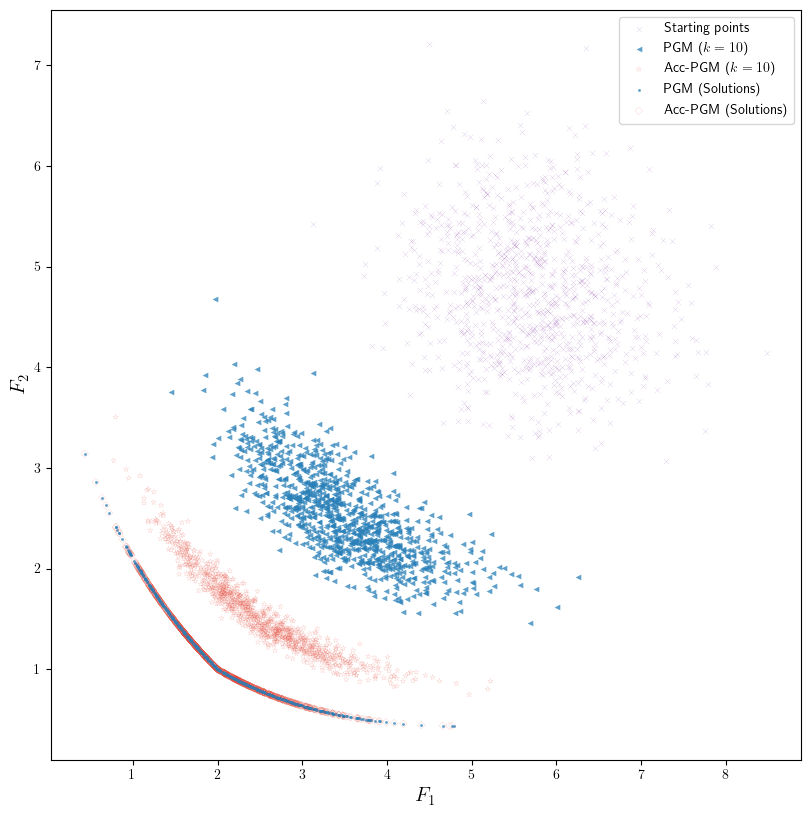

In [23]:
show_Pareto_front(problem_JOS1_L1, results_JOS1_L1, results_acc_JOS1_L1, step=10, fname='JOS1_L1.pdf')

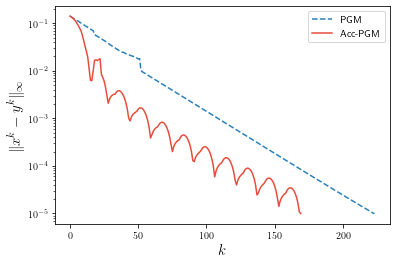

In [24]:
plt.yscale('log')
plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$\|x^k - y^k\|_\infty$', fontsize=15)
plt.plot(results_JOS1_L1[0].all_error_criteria, color="#2980b9", label="PGM", linestyle="dashed")
plt.plot(results_acc_JOS1_L1[0].all_error_criteria, color="#e74c3c", label="Acc-PGM")
plt.legend()
plt.savefig(fig_path + '/JOS1_L1_error.pdf', bbox_inches='tight')

## SD
Minimize
$$F_1(x) = 2 x_1 + \sqrt{2} x_2 + \sqrt{2} x_3 + x_4, \quad F_2(x) = \frac{2}{x_1} + \frac{2 \sqrt{2}}{x_2} + \frac{2 \sqrt{2}}{x_3} + \frac{2}{x_4}$$
subject to $(1, \sqrt{2}, \sqrt{2}, 1)^\top \le x \le (3, 3, 3, 3)^\top$.

In [25]:
problem_SD = SD()
start_points_SD = generate_start_points(low=problem_SD.lb, high=problem_SD.ub,
                                     n_dims=problem_SD.n_dims)

### Proximal Gradient Method

In [26]:
results_SD = run(problem_SD, start_points_SD)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1

### Accelerated Proximal Gradient Method

In [27]:
results_acc_SD = run(problem_SD, start_points_SD, nesterov=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1

### Complexity

In [28]:
stats_SD = {'PGM': get_stats(results_SD), 'Acc-PGM': get_stats(results_acc_SD)}
pprint.pprint(stats_SD)

{'Acc-PGM': {'execusion_time': {'max': 5.75710916519165,
                                'mean': 2.974809938430786,
                                'std': 0.6232684355328332},
             'nit': {'max': 59, 'mean': 37.175, 'std': 7.26253227187322},
             'nit_internal': {'max': 1003,
                              'mean': 567.376,
                              'std': 116.96695526515171}},
 'PGM': {'execusion_time': {'max': 5.753604173660278,
                            'mean': 2.896836669921875,
                            'std': 0.7142021404183051},
         'nit': {'max': 70, 'mean': 39.326, 'std': 9.838583434621063},
         'nit_internal': {'max': 1189,
                          'mean': 600.64,
                          'std': 160.17505548617737}}}


0it [00:00, ?it/s]

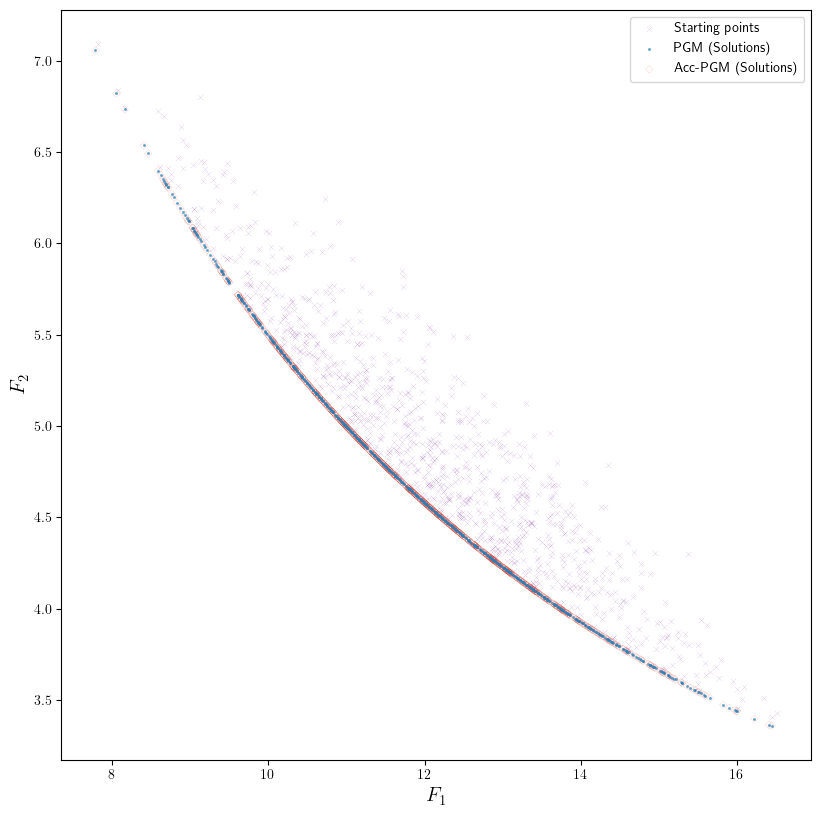

In [29]:
%matplotlib inline
show_Pareto_front(problem_SD, results_SD, results_acc_SD, fname='SD.pdf')

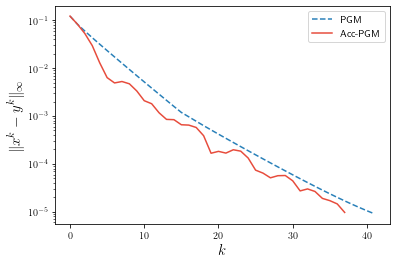

In [30]:
plt.yscale('log')
plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$\|x^k - y^k\|_\infty$', fontsize=15)
plt.plot(results_SD[0].all_error_criteria, color="#2980b9", label="PGM", linestyle="dashed")
plt.plot(results_acc_SD[0].all_error_criteria, color="#e74c3c", label="Acc-PGM")
plt.legend()
plt.savefig(fig_path + '/SD_error.pdf', bbox_inches='tight')

## FDS
Minimize
$$F_1(x) = \frac{1}{n^2} \sum_{i = 1}^n i (x_i - i)^4, \quad F_2(x) = \exp \left( \sum_{i = 1}^n \frac{x_i}{n} \right) + \|x\|_2^2, \quad F_3(x) = \frac{1}{n(n + 1)} \sum_{i = 1}^n i (n - i + 1) \exp (- x_i)$$
subject to $x \in \mathbf{R}^n$.

In [31]:
n_dims = 10
problem_FDS = FDS(n_dims=n_dims)
start_points_FDS = generate_start_points(low=-2, high=2, n_dims=n_dims)

### Proximal Gradient Method

In [32]:
results_FDS = run(problem_FDS, start_points_FDS)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 29.9min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 33.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 37

### Accelerated Proximal Gradient Method

In [33]:
results_acc_FDS = run(problem_FDS, start_points_FDS, nesterov=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 13

### Complexity

In [34]:
stats_FDS = {'PGM': get_stats(results_FDS), 'Acc-PGM': get_stats(results_acc_FDS)}
pprint.pprint(stats_FDS)

{'Acc-PGM': {'execusion_time': {'max': 66.88845539093018,
                                'mean': 34.160296491861345,
                                'std': 9.849184000667888},
             'nit': {'max': 444, 'mean': 216.132, 'std': 63.81627203151246},
             'nit_internal': {'max': 15527,
                              'mean': 7579.335,
                              'std': 2180.166480059493}},
 'PGM': {'execusion_time': {'max': 375.6508319377899,
                            'mean': 99.09484929299354,
                            'std': 61.37960258584378},
         'nit': {'max': 2456, 'mean': 636.084, 'std': 428.2531972373353},
         'nit_internal': {'max': 83639,
                          'mean': 22352.069,
                          'std': 14071.607937838482}}}


0it [00:00, ?it/s]

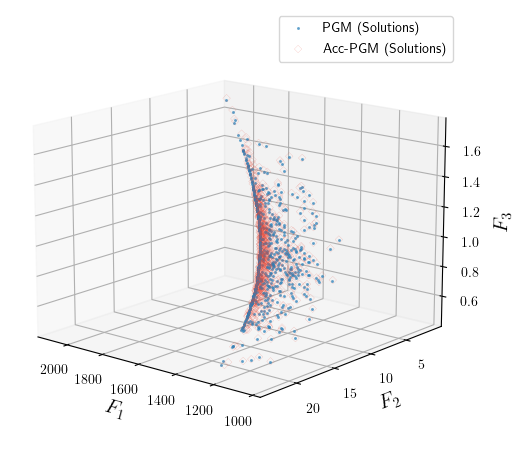

In [35]:
%matplotlib inline
show_Pareto_front(problem_FDS, results_FDS, results_acc_FDS, fname='FDS.pdf')

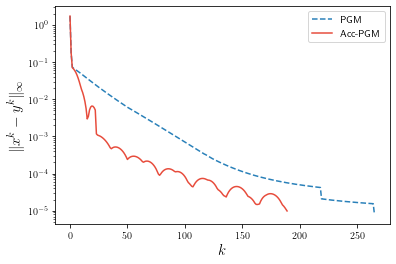

In [36]:
plt.yscale('log')
plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$\|x^k - y^k\|_\infty$', fontsize=15)
plt.plot(results_FDS[0].all_error_criteria, color="#2980b9", label="PGM", linestyle="dashed")
plt.plot(results_acc_FDS[0].all_error_criteria, color="#e74c3c", label="Acc-PGM")
plt.legend()
plt.savefig(fig_path + '/FDS_error.pdf', bbox_inches='tight')

## FDS CONSTRAINED
Minimize
$$F_1(x) = \frac{1}{n^2} \sum_{i = 1}^n i (x_i - i)^4, \quad F_2(x) = \exp \left( \sum_{i = 1}^n \frac{x_i}{n} \right) + \|x\|_2^2, \quad F_3(x) = \frac{1}{n(n + 1)} \sum_{i = 1}^n i (n - i + 1) \exp (- x_i)$$
subject to $x \in \mathbf{R}_+^n$.

In [37]:
n_dims = 10
problem_FDS_CONSTRAINED = FDS_CONSTRAINED(n_dims=n_dims)
start_points_FDS_CONSTRAINED = generate_start_points(low=0, high=2, n_dims=n_dims)

In [38]:
results_FDS_CONSTRAINED = run(problem_FDS_CONSTRAINED, start_points_FDS_CONSTRAINED)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 24.3min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 28.8min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 32.3min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 37.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 44.3min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 50.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 54

In [39]:
results_acc_FDS_CONSTRAINED = run(problem_FDS_CONSTRAINED, start_points_FDS_CONSTRAINED, nesterov=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 15

In [40]:
stats_FDS_CONSTRAINED = {'PGM': get_stats(results_FDS_CONSTRAINED), 'Acc-PGM': get_stats(results_acc_FDS_CONSTRAINED)}
pprint.pprint(stats_FDS_CONSTRAINED)

{'Acc-PGM': {'execusion_time': {'max': 102.99057269096375,
                                'mean': 40.033090000391006,
                                'std': 11.481535828354975},
             'nit': {'max': 734, 'mean': 260.78, 'std': 85.19851876646682},
             'nit_internal': {'max': 23779,
                              'mean': 9190.734,
                              'std': 2677.6220008141554}},
 'PGM': {'execusion_time': {'max': 432.8255989551544,
                            'mean': 134.6351037604809,
                            'std': 66.45550454216297},
         'nit': {'max': 3100, 'mean': 873.632, 'std': 472.1703109853477},
         'nit_internal': {'max': 98741,
                          'mean': 30530.871,
                          'std': 15236.09749175815}}}


0it [00:00, ?it/s]

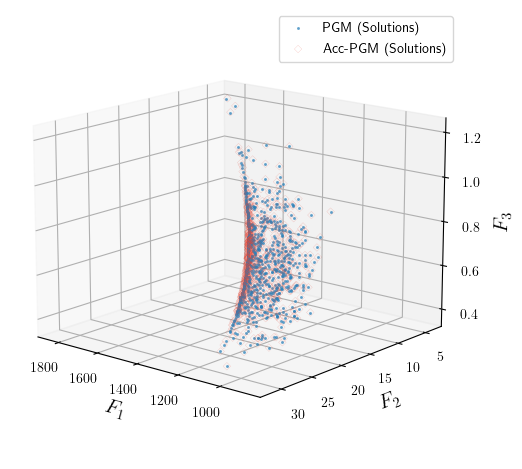

In [41]:
%matplotlib inline
show_Pareto_front(problem_FDS_CONSTRAINED, results_FDS_CONSTRAINED, results_acc_FDS_CONSTRAINED, fname='FDS_CONSTRAINED.pdf')

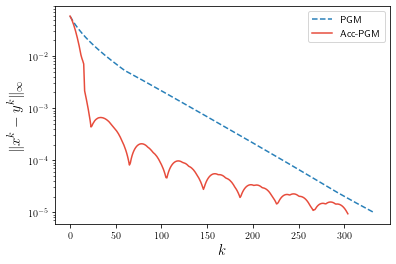

In [42]:
plt.yscale('log')
plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$\|x^k - y^k\|_\infty$', fontsize=15)
plt.plot(results_FDS_CONSTRAINED[0].all_error_criteria, color="#2980b9", label="PGM", linestyle="dashed")
plt.plot(results_acc_FDS_CONSTRAINED[0].all_error_criteria, color="#e74c3c", label="Acc-PGM")
plt.legend()
plt.savefig(fig_path + '/FDS_CONSTRAINED_error.pdf', bbox_inches='tight')